# Google Image Search Baseline Analysis for Hillary Clinton and Donald Trump Images

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## Scrape images and metadata from the saved web search source file

### Run `1_extract_images_urls.py` script 
* This script reads the htm source file saved from the Google Image search results page for the queries 'hillary clinton' or 'donald trump' for images from the 3rd September 2016 to the 28th October 2016.
* output will be:
    - meta data saved in `donald_trump_image_universe.csv` or `hillary_clinton_image_universe.csv`
    - Images saved in `donald_trump_image_universe` or `hillary_clinton_image_universe` directories

## Manually check images:
* Remove images that are not of the candidate
* Remove images where there are mulitple faces
* Manually collect images that failed to download properly. This is sometimes because more time was needed to scrape it

### Run `2_remove_rejected_from_data.py` script
* Removes rows from the `donald_trump_image_universe.csv` or `hillary_clinton_image_universe.csv` spreadsheets, so it correctly references the remaining images in the `donald_trump_image_universe` or `hillary_clinton_image_universe` image directories.

## Programatically identify unique images 
* Read in each image, calculate a unique hash based on the image data, a bit like a fingerprint, and store the hash along with the image filename in a shelf (a persistent dictionary). Many images were repeats, so there were many image filenames stored with the same hash key. 

* The code is based on this blog post: https://realpython.com/blog/python/fingerprinting-images-for-near-duplicate-detection/ which I adapted to work with Python3

In [ ]:
%run ../index.py --dataset ./hillary_clinton_image_universe --shelve hc_baseline.shelve

In [ ]:
%run ../index.py --dataset ./donald_trump_image_universe --shelve dt_baseline.shelve

## Add the hash to each row in our `hillary_clinton_remaining_images.csv` and `donald_trump_remaining_images.csv` dataframes

In [ ]:
import shelve

In [ ]:
# This is the same as script `3_baseline_imagesintoDF.py`

def add_hash_to_DF(shelf, data_csv, candidate):
    
    db = shelve.open(shelf + '.shelve')
    
    data = pd.read_csv(data_csv)

    for key in db.keys():   #  For every hash KEY
        for f in db[key]:   # for every file path name ITEM within the KEY
            for index, i in enumerate(data['image_file']):   # For every Image path in each row of my DF
                if f == i:                                   # If the ITEM file path is also in the IMAGE PATH of my DF
                    data.loc[index, 'image_hash'] = key      # Put the KEY into the 'image_hash' Column

    data.to_csv(candidate + "_baseline_hashedDF.csv", index=False)

    db.close()

In [ ]:
add_hash_to_DF('hc_baseline', 'hillary_clinton_remaining_images.csv', 'HC' )

In [ ]:
add_hash_to_DF('dt_baseline', 'donald_trump_remaining_images.csv', 'DT' )

## Read in Google Scraper search results table 

In [ ]:
tmp = pd.read_csv('HC_baseline_hashedDF.csv', nrows=2)
tmp

In [2]:
cols = ['candidate', 'image_file', 'image_url', 'news_source', 'news_source_url', 'image_hash']

In [3]:
HC = pd.read_csv('HC_baseline_hashedDF.csv', usecols=cols)
DT = pd.read_csv('DT_baseline_hashedDF.csv', usecols=cols)
print(len(HC))
print(len(DT))

353
298


___
# NEWS SOURCE INFORMATION

In [4]:
HC.news_source.describe()

count                  353
unique                 144
top       Business Insider
freq                    16
Name: news_source, dtype: object

In [5]:
DT.news_source.describe()

count                  298
unique                 110
top       Business Insider
freq                    21
Name: news_source, dtype: object

In [6]:
HC.news_source_url.describe()

count                                                   353
unique                                                  330
top       http://www.harpersbazaar.com/celebrity/red-car...
freq                                                      5
Name: news_source_url, dtype: object

In [7]:
DT.news_source_url.describe()

count                                                   298
unique                                                  282
top       http://www.reviewjournal.com/opinion/editorial...
freq                                                      4
Name: news_source_url, dtype: object

## Getting Political Leaning from [Allsides](https://www.allsides.com) from News Sources of all images in basline dataset

![allsides](../logo-all-sides-medium.png) 
Allsides bias data was generously provided by [Allsides](https://www.allsides.com) 


In [9]:
def tag_bias_rating(candidate):
    
    candidate['allsides_bias_rating'] = 999
    allsides = pd.read_json('allsides_data.json')

    for i, valuei in enumerate(candidate.news_source):
        valuei = valuei.strip('.com')
        if valuei == 'The Telegraph':
            valuei = 'The Telegraph - UK'
            
        for j, valuej in enumerate(allsides.news_source):
            
            # this `if` line is necessary due to `st`, `t` and `s` being inexplicably stripped from 
            # the ends of news sources (eg Washington Po, The Federali). Best reason I can think of 
            # is that it happened during `extract_images_urls.py` since the meta data we strip "st:" 
            # meta_tags from the content of those tags...
            if valuei == valuej.strip('st') or valuei == valuej.strip('s') or valuei == valuej.strip('t'):                  
                    
                if allsides.loc[j, 'bias_rating'] == 71: # Left
                    candidate.loc[i, 'allsides_bias_rating'] = -2
                    
                elif allsides.loc[j, 'bias_rating'] == 72: # Lean left
                    candidate.loc[i, 'allsides_bias_rating'] = -1
                    
                elif allsides.loc[j, 'bias_rating'] == 73: # center
                    candidate.loc[i, 'allsides_bias_rating'] = 0
                    
                elif allsides.loc[j, 'bias_rating'] == 74: # lean right
                    candidate.loc[i, 'allsides_bias_rating'] = 1      
                    
                elif allsides.loc[j, 'bias_rating'] == 75: # Right
                    candidate.loc[i, 'allsides_bias_rating'] = 2                   
                   
                else:
                    candidate.loc[i, 'allsides_bias_rating'] = 999

In [ ]:
def tag_bias_rating_test(candidate):
    
    candidate['allsides_bias_rating'] = 999
    allsides = pd.read_json('allsides_data.json')

    for i, valuei in enumerate(candidate.news_source.unique()):
        valuei = valuei.strip('.com')
        if valuei == 'The Telegraph':
            valuei = 'The Telegraph - UK'
            
        for j, valuej in enumerate(allsides.news_source.unique()):

            if valuei in valuej.strip('st') or valuei in valuej.strip('s') or valuei in valuej.strip('t'):  
                print("i: ", valuei, " j: ", valuej)

In [ ]:
tag_bias_rating_test(HC)

In [10]:
tag_bias_rating(HC)
tag_bias_rating(DT)

In [11]:
HC.allsides_bias_rating.value_counts()

 999    216
 0       39
 1       34
-2       28
-1       20
 2       16
Name: allsides_bias_rating, dtype: int64

In [12]:
DT.allsides_bias_rating.value_counts()

 999    180
 0       49
-2       37
-1       18
 1        8
 2        6
Name: allsides_bias_rating, dtype: int64

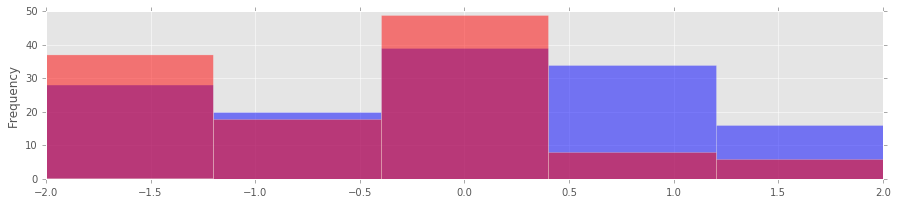

In [39]:
HC.allsides_bias_rating[HC.allsides_bias_rating < 3].plot.hist(alpha=0.5, color='blue', bins=5)
DT.allsides_bias_rating[DT.allsides_bias_rating < 3].plot.hist(alpha=0.5, color='red',bins=5)

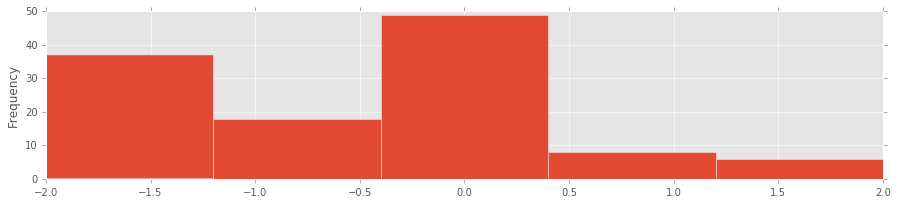

In [38]:
DT.allsides_bias_rating[DT.allsides_bias_rating < 3].plot.hist(bins=5)

In [ ]:
HC[HC.allsides_bias_rating == 999].news_source.unique()

In [ ]:
len(HC[HC.allsides_bias_rating == 999].news_source.unique())

In [ ]:
DT[DT.allsides_bias_rating == 999].news_source.unique()

In [ ]:
'YouTube' in DT.news_source.unique()

In [ ]:
len(HC[HC.allsides_bias_rating == 999].news_source.unique())

## Getting political leaning from a [Facebook political bias ratings study](http://science.sciencemag.org/content/early/2015/05/06/science.aaa1160)
Data is available [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LDJ7MS)

In [18]:
facebook = pd.read_csv('../Facebook_study.csv')

In [19]:
facebook.head()

,p,avg_align,Unnamed: 2,Unnamed: 3,Unnamed: 4,Source,top_level_link,top_level_link_cleaned,avg_align.1,Total_articles
0,6abc.com,-0.5037,NaN,NaN,NaN,The Hill,http://thehill.com/,thehill.com,0.1661,30.0
1,7online.com,-0.4067,NaN,NaN,NaN,Politico,http://www.politico.com/,politico.com,-0.1334,27.0
2,aattp.org,-0.8936,NaN,NaN,NaN,The Washington Post,https://www.washingtonpost.com,washingtonpost.com,-0.2568,25.0
3,abc11.com,-0.1900,NaN,NaN,NaN,The Huffington Post,http://www.huffingtonpost.com/,huffingtonpost.com,-0.6176,21.0
4,abc7.com,-0.3100,NaN,NaN,NaN,New York Times,http://www.nytimes.com/,nytimes.com,-0.5469,18.0


In [20]:
cols = ['p', 'avg_align']
facebook = pd.read_csv('../Facebook_study.csv', usecols=cols)
facebook.head()

,p,avg_align
0,6abc.com,-0.5037
1,7online.com,-0.4067
2,aattp.org,-0.8936
3,abc11.com,-0.1900
4,abc7.com,-0.3100


In [21]:
def tag_facebookbias_rating(candidate):
    
    candidate['facebook_p'] = ''
    candidate['facebookbias_rating'] = 999
    
    for i, valuei in enumerate(candidate.news_source_url):
        valuei = valuei.split('//')[1]
        valuei = valuei.split('/')[0]
        
        for j, valuej in enumerate(facebook.p):
            
            if valuej == valuei:                  
                print(valuei, valuej)
                candidate.loc[i, 'facebookbias_rating'] = facebook.loc[j, 'avg_align']
                candidate.loc[i, 'facebook_p'] = valuej

In [22]:
tag_facebookbias_rating(HC)
tag_facebookbias_rating(DT)

www.cnn.com www.cnn.com
thefederalist.com thefederalist.com
www.huffingtonpost.com www.huffingtonpost.com
www.salon.com www.salon.com
www.businessinsider.com www.businessinsider.com
www.businessinsider.com www.businessinsider.com
www.businessinsider.com www.businessinsider.com
www.cnn.com www.cnn.com
www.denverpost.com www.denverpost.com
www.cnn.com www.cnn.com
www.breitbart.com www.breitbart.com
www.businessinsider.com www.businessinsider.com
www.cnbc.com www.cnbc.com
www.newyorker.com www.newyorker.com
www.politico.com www.politico.com
www.nj.com www.nj.com
www.businessinsider.com www.businessinsider.com
www.thedailybeast.com www.thedailybeast.com
www.chicagotribune.com www.chicagotribune.com
thefederalist.com thefederalist.com
www.thegatewaypundit.com www.thegatewaypundit.com
legalinsurrection.com legalinsurrection.com
www.telegraph.co.uk www.telegraph.co.uk
www.breitbart.com www.breitbart.com
www.newyorker.com www.newyorker.com
www.npr.org www.npr.org
www.telegraph.co.uk www.telegr

In [23]:
HC.head()

,candidate,image_file,image_url,news_source,news_source_url,image_hash,allsides_bias_rating,facebook_p,facebookbias_rating
0,hillary_clinton,0_hillary_clinton.jpg,http://pixel.nymag.com/imgs/fashion/daily/2016...,New York Magazine,http://nymag.com/thecut/2016/09/hillary-clinto...,1d1a1a9e1e1b0d0f,-2,,999.0000
1,hillary_clinton,1_hillary_clinton.jpg,http://i2.cdn.cnn.com/cnnnext/dam/assets/16101...,CNN.com,http://www.cnn.com/2016/12/21/politics/donald-...,efd3d3a9dbd2a1e1,0,www.cnn.com,-0.2705
2,hillary_clinton,2_hillary_clinton.jpg,http://cdn.thefederalist.com/wp-content/upload...,The Federali,http://thefederalist.com/2016/10/20/the-five-m...,9f9d8f9ddf193656,1,thefederalist.com,0.8559
3,hillary_clinton,3_hillary_clinton.jpg,http://i.huffpost.com/gen/4727452/images/n-HIL...,The Huffington Po,http://www.huffingtonpost.com/isaac-saul/i-wro...,9819181899191c18,999,www.huffingtonpost.com,-0.6176
4,hillary_clinton,4_hillary_clinton.jpg,http://media.salon.com/2016/10/hillary_clinton...,Salon,http://www.salon.com/2016/10/20/hillary-clinto...,4c0c0c4914363f3f,-2,www.salon.com,-0.8753


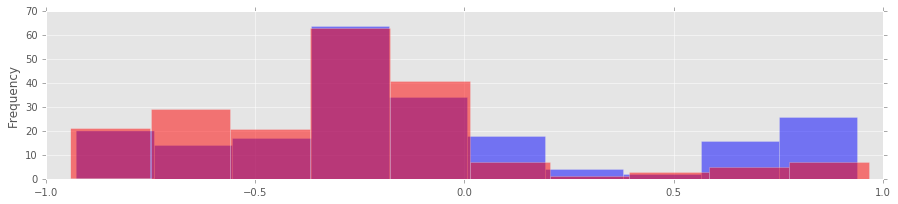

In [36]:
HC.facebookbias_rating[HC.facebookbias_rating < 3].plot.hist(alpha=0.5, color='blue')
DT.facebookbias_rating[DT.facebookbias_rating < 3].plot.hist(alpha=0.5, color='red')

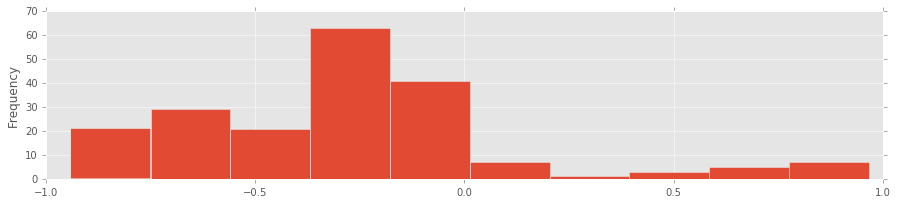

In [25]:
DT.facebookbias_rating[DT.facebookbias_rating < 3].plot.hist()

# Combining ratings from Allsides and Facebook, together with crowdsourced political bias ratings from [Mondo Times](www.mondotimes.com) and author's judgement

#### First, Facebook ratings were categoriesed into 2, 1, 0, -1, and -2 integers so as to be compatable with the Allsides data. Between-category thresholds were selected so as to make each bucket equal in float range of values. 

In [26]:
def convert_facebookbias_toInts(col):
    
    if col >= 0.6 and col <= 1:
        return 2
    elif col >= 0.2 and col < 0.6:
        return 1
    elif col > -0.2 and col < 0.2:
        return 0
    elif col > -0.6 and col <= -0.2:
        return -1
    elif col <= -0.6:
        return -2
    elif col == 999:
        return 999
    else:
        return 999

In [27]:
HC['facebook_int'] = HC.facebookbias_rating.apply(convert_facebookbias_toInts)
DT['facebook_int'] = DT.facebookbias_rating.apply(convert_facebookbias_toInts)

In [28]:
HC.head()

,candidate,image_file,image_url,news_source,news_source_url,image_hash,allsides_bias_rating,facebook_p,facebookbias_rating,facebook_int
0,hillary_clinton,0_hillary_clinton.jpg,http://pixel.nymag.com/imgs/fashion/daily/2016...,New York Magazine,http://nymag.com/thecut/2016/09/hillary-clinto...,1d1a1a9e1e1b0d0f,-2,,999.0000,999
1,hillary_clinton,1_hillary_clinton.jpg,http://i2.cdn.cnn.com/cnnnext/dam/assets/16101...,CNN.com,http://www.cnn.com/2016/12/21/politics/donald-...,efd3d3a9dbd2a1e1,0,www.cnn.com,-0.2705,-1
2,hillary_clinton,2_hillary_clinton.jpg,http://cdn.thefederalist.com/wp-content/upload...,The Federali,http://thefederalist.com/2016/10/20/the-five-m...,9f9d8f9ddf193656,1,thefederalist.com,0.8559,2
3,hillary_clinton,3_hillary_clinton.jpg,http://i.huffpost.com/gen/4727452/images/n-HIL...,The Huffington Po,http://www.huffingtonpost.com/isaac-saul/i-wro...,9819181899191c18,999,www.huffingtonpost.com,-0.6176,-2
4,hillary_clinton,4_hillary_clinton.jpg,http://media.salon.com/2016/10/hillary_clinton...,Salon,http://www.salon.com/2016/10/20/hillary-clinto...,4c0c0c4914363f3f,-2,www.salon.com,-0.8753,-2


In [40]:
HC.facebook_int.value_counts()

 999    138
-1       84
 0       52
 2       41
-2       31
 1        7
Name: facebook_int, dtype: int64

In [30]:
DT.facebook_int.value_counts()

 999    100
-1       86
-2       48
 0       48
 2       12
 1        4
Name: facebook_int, dtype: int64

#### Next, ratings from Allsides and the Facebook study were combined. Where ratings from both Allsides and Facebook are absent, or disagree, bias rating was decided by Mondo Times where an outlet received more than 20 votes, and /or the author based on outlets' "About" pages and other information. Where doubt remained, or ratings are not applicable (eg. Getty Images), `Unknown / Unreliable` was assigned. 

In [31]:
def combine_ratings(candidate):
    
    candidate['combine_rating'] = ''
    
    for i, valuei in enumerate(candidate.allsides_bias_rating):
            
        # STATEMENTS FOR IF BOTH RATINGS AGREE:
        # Both bias ratings say LEFT
        if (valuei < 0) and (candidate.loc[i, 'facebook_int'] < 0):
            print(valuei, candidate.loc[i, 'facebook_int'],  "Left")
            candidate.loc[i, 'combine_rating'] = "Left"
          
        # Both bias ratings say CENTER
        elif (valuei == 0.0) and (candidate.loc[i, 'facebook_int'] == 0):
            print(valuei, candidate.loc[i, 'facebook_int'],  "Center")
            candidate.loc[i, 'combine_rating'] = "Center"
        
        # Both bias ratings say RIGHT
        elif (0 < valuei < 3) and (0 < candidate.loc[i, 'facebook_int'] < 3):
            print(valuei, candidate.loc[i, 'facebook_int'], "Right")
            candidate.loc[i, 'combine_rating'] = "Right"
        
        # STATEMENTS FOR IF RATINGS ARE ONLY PRESENT IN ONE (ALLSIDES OR FACEBOOK STUDY)
        # Only one scale has a rating of LEFT, while the other has no entry 
        elif (valuei < 0 and candidate.loc[i, 'facebook_int'] == 999) or (valuei == 999 and candidate.loc[i, 'facebook_int'] < 0):
            print(valuei, candidate.loc[i, 'facebook_int'],  "Left")
            candidate.loc[i, 'combine_rating'] = "Left"
            
        # Only one scale has a rating of CENTER, while the other has no entry 
        elif (valuei == 0 and candidate.loc[i, 'facebook_int'] == 999) or (valuei  == 999 and candidate.loc[i, 'facebook_int'] == 0):
            print(valuei, candidate.loc[i, 'facebook_int'],  "Center")
            candidate.loc[i, 'combine_rating'] = "Center"
        
        # Only one scale has a rating of RIGHT, while the other has no entry
        elif (0 < valuei < 3 and candidate.loc[i, 'facebook_int'] == 999) or (valuei  == 999 and 0 < candidate.loc[i, 'facebook_int'] < 3):
            print(valuei, candidate.loc[i, 'facebook_int'], "Right")
            candidate.loc[i, 'combine_rating'] = "Right"
             
        # ALL OTHER RATINGS ARE EITHER ABSENT FOR BOTH SCALES OR THE SCALES DISAGREE
        else:
            print(valuei, candidate.loc[i, 'facebook_int'], "Not Rated")
            candidate.loc[i, 'combine_rating'] = "Unknown / unreliable"

In [41]:
combine_ratings(HC)
combine_ratings(DT)

-2 999 Left
0 -1 Not Rated
1 2 Right
999 -2 Left
-2 -2 Left
0 0 Center
0 0 Center
999 999 Not Rated
0 0 Center
999 999 Not Rated
0 -1 Not Rated
999 999 Not Rated
999 -1 Left
0 -1 Not Rated
2 2 Right
999 999 Not Rated
999 999 Not Rated
0 0 Center
0 0 Center
999 999 Not Rated
999 -2 Left
999 0 Center
999 999 Not Rated
999 -1 Left
999 999 Not Rated
0 0 Center
999 -1 Left
0 -1 Not Rated
999 999 Not Rated
1 2 Right
2 2 Right
999 2 Right
999 999 Not Rated
999 999 Not Rated
999 999 Not Rated
1 0 Not Rated
2 2 Right
999 999 Not Rated
999 999 Not Rated
999 999 Not Rated
999 -2 Left
0 -2 Not Rated
1 0 Not Rated
-2 -1 Left
999 999 Not Rated
0 0 Center
999 0 Center
2 2 Right
999 999 Not Rated
999 999 Not Rated
999 999 Not Rated
-1 -1 Left
999 -1 Left
999 -2 Left
-2 -1 Left
999 -2 Left
-2 999 Left
999 999 Not Rated
2 2 Right
999 999 Not Rated
999 -1 Left
-2 -1 Left
999 999 Not Rated
999 999 Not Rated
-2 999 Left
999 -2 Left
999 999 Not Rated
999 999 Not Rated
999 999 Not Rated
-1 -1 Left
0 -1 Not R

In [42]:
HC.combine_rating.value_counts()

Unknown / unreliable    157
Left                    111
Right                    48
Center                   37
Name: combine_rating, dtype: int64

In [43]:
DT.combine_rating.value_counts()

Left                    125
Unknown / unreliable    110
Center                   46
Right                    17
Name: combine_rating, dtype: int64

In [ ]:
#HC.to_csv('HC_Baseline_NEW.csv', index=False)

In [ ]:
#DT.to_csv('DT_Baseline_NEW.csv', index=False)

In [44]:
HC_Unrated = HC[HC.combine_rating == "Unknown / unreliable"]
DT_Unrated = DT[DT.combine_rating == "Unknown / unreliable"]

In [ ]:
#HC_Unrated.to_csv("HC_Baseline_Unrated_NEW.csv", index=False)
#DT_Unrated.to_csv("DT_Baseline_Unrated_NEW.csv", index=False)

#### Make list of unique news sources, combine lists together from HC and DT, and output to a csv:

In [48]:
Unrated_newssource_list = HC_Unrated.news_source.unique().tolist()
DT_Unrated_newssource_list = DT_Unrated.news_source.unique().tolist()

In [49]:
print(len(Unrated_newssource_list))
print(len(DT_Unrated_newssource_list))

83
59


In [50]:
for i in DT_Unrated_newssource_list:
    if i not in Unrated_newssource_list:
        Unrated_newssource_list.append(i)

In [51]:
len(Unrated_newssource_list)

119

In [52]:
tmp = pd.DataFrame(Unrated_newssource_list, columns=["news_source"])
tmp.to_csv('unrated_newssources.csv', index=False)

#### Read in my manual bias ratings:

In [53]:
manual_rating = pd.read_excel('Unrated_newssource_final.xlsx')

In [54]:
manual_rating.head()

,news_source,final_rating
0,National Enquirer,999
1,THE VOTER,999
2,Money Nation,999
3,Inquirer New,999
4,Conservative Review,1


In [55]:
HC.head()

,candidate,image_file,image_url,news_source,news_source_url,image_hash,allsides_bias_rating,facebook_p,facebookbias_rating,facebook_int,combine_rating
0,hillary_clinton,0_hillary_clinton.jpg,http://pixel.nymag.com/imgs/fashion/daily/2016...,New York Magazine,http://nymag.com/thecut/2016/09/hillary-clinto...,1d1a1a9e1e1b0d0f,-2,,999.0000,999,Left
1,hillary_clinton,1_hillary_clinton.jpg,http://i2.cdn.cnn.com/cnnnext/dam/assets/16101...,CNN.com,http://www.cnn.com/2016/12/21/politics/donald-...,efd3d3a9dbd2a1e1,0,www.cnn.com,-0.2705,-1,Unknown / unreliable
2,hillary_clinton,2_hillary_clinton.jpg,http://cdn.thefederalist.com/wp-content/upload...,The Federali,http://thefederalist.com/2016/10/20/the-five-m...,9f9d8f9ddf193656,1,thefederalist.com,0.8559,2,Right
3,hillary_clinton,3_hillary_clinton.jpg,http://i.huffpost.com/gen/4727452/images/n-HIL...,The Huffington Po,http://www.huffingtonpost.com/isaac-saul/i-wro...,9819181899191c18,999,www.huffingtonpost.com,-0.6176,-2,Left
4,hillary_clinton,4_hillary_clinton.jpg,http://media.salon.com/2016/10/hillary_clinton...,Salon,http://www.salon.com/2016/10/20/hillary-clinto...,4c0c0c4914363f3f,-2,www.salon.com,-0.8753,-2,Left


In [118]:
def merge_manual_ratings(candidate):
    
    candidate['final_rating'] = ''
    
    for i, valuei in enumerate(candidate.news_source):
        for j, valuej in enumerate(manual_rating.news_source):
            
            if (valuei == valuej):
                print(valuei, valuej, manual_rating.loc[j, 'final_rating'])
                
                if manual_rating.loc[j, 'final_rating'] < 0:
                    print("Left")
                    candidate.loc[i, 'final_rating'] = "Left"
                    
                elif manual_rating.loc[j, 'final_rating'] == 0:
                    print("Center")
                    candidate.loc[i, 'final_rating'] = "Center"
                    
                elif 999 > manual_rating.loc[j, 'final_rating'] > 0:
                    print("Right")
                    candidate.loc[i, 'final_rating'] = "Right"
                    
                elif manual_rating.loc[j, 'final_rating'] == 999:
                    print("Unknown/Unreliable")
                    candidate.loc[i, 'final_rating'] = "Unknown / unreliable"
    
            
    for i, valuei in enumerate(candidate.final_rating):
        if valuei == '':
            print("currently empty. Let's fill it up!!")
            candidate.loc[i, 'final_rating'] = candidate.loc[i, 'combine_rating']
        

In [119]:
merge_manual_ratings(HC)
merge_manual_ratings(DT)

CNN.com CNN.com 0
Center
Daily Expre Daily Expre 1
Right
Cincinnati Enquirer Cincinnati Enquirer 0
Center
CNN.com CNN.com 0
Center
People People 1
Right
CNN.com CNN.com 0
Center
Reveli Reveli -1
Left
Us Weekly Us Weekly 999
Unknown/Unreliable
Daily Expre Daily Expre 1
Right
Deadline Deadline 0
Center
Star Tribune Star Tribune -1
Left
Chicago Tribune Chicago Tribune 0
Center
WBUR WBUR -1
Left
Deadline Deadline 0
Center
Conservative Review Conservative Review 1
Right
Psychology Today Psychology Today 999
Unknown/Unreliable
The Telegraph The Telegraph 1
Right
The Forward The Forward 0
Center
Investor\u0027s Business Daily Investor\u0027s Business Daily 0
Center
Encyclopedia Britannica Encyclopedia Britannica 999
Unknown/Unreliable
NPR NPR -1
Left
The Telegraph The Telegraph 1
Right
Snopes.com Snopes.com 0
Center
Radar Online Radar Online 999
Unknown/Unreliable
The American Mirror The American Mirror 1
Right
Daily Expre Daily Expre 1
Right
National Enquirer National Enquirer 999
Unknown/Un

In [120]:
HC.head()

,candidate,image_file,image_url,news_source,news_source_url,image_hash,allsides_bias_rating,facebook_p,facebookbias_rating,facebook_int,combine_rating,final_rating
0,hillary_clinton,0_hillary_clinton.jpg,http://pixel.nymag.com/imgs/fashion/daily/2016...,New York Magazine,http://nymag.com/thecut/2016/09/hillary-clinto...,1d1a1a9e1e1b0d0f,-2,,999.0000,999,Left,Left
1,hillary_clinton,1_hillary_clinton.jpg,http://i2.cdn.cnn.com/cnnnext/dam/assets/16101...,CNN.com,http://www.cnn.com/2016/12/21/politics/donald-...,efd3d3a9dbd2a1e1,0,www.cnn.com,-0.2705,-1,Unknown / unreliable,Center
2,hillary_clinton,2_hillary_clinton.jpg,http://cdn.thefederalist.com/wp-content/upload...,The Federali,http://thefederalist.com/2016/10/20/the-five-m...,9f9d8f9ddf193656,1,thefederalist.com,0.8559,2,Right,Right
3,hillary_clinton,3_hillary_clinton.jpg,http://i.huffpost.com/gen/4727452/images/n-HIL...,The Huffington Po,http://www.huffingtonpost.com/isaac-saul/i-wro...,9819181899191c18,999,www.huffingtonpost.com,-0.6176,-2,Left,Left
4,hillary_clinton,4_hillary_clinton.jpg,http://media.salon.com/2016/10/hillary_clinton...,Salon,http://www.salon.com/2016/10/20/hillary-clinto...,4c0c0c4914363f3f,-2,www.salon.com,-0.8753,-2,Left,Left


In [122]:
HC.final_rating.value_counts()

Left                    145
Center                   92
Right                    75
Unknown / unreliable     41
Name: final_rating, dtype: int64

In [124]:
DT.final_rating.value_counts()

Left                    154
Center                   88
Right                    33
Unknown / unreliable     23
Name: final_rating, dtype: int64